In [16]:
%cd C:\Users\alexw\Desktop\nlp\Final Project

C:\Users\alexw\Desktop\nlp\Final Project


In [17]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

In [18]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
dir_dataset = "archive"
file_business = os.path.join(dir_dataset, "yelp_academic_dataset_business.json")
file_review = os.path.join(dir_dataset, "yelp_academic_dataset_review.json")

In [20]:
def get_restaurants(file_business):
  with open(file_business, 'r') as file:
    restaurants = set()

    for json_str in file:
      obj = json.loads(json_str)
      if obj["business_id"] and obj["categories"] \
      and "restaurants" in obj["categories"].lower():
        restaurants.add(obj["business_id"])

    return restaurants

In [21]:
%time restaurants = get_restaurants(file_business)

CPU times: total: 312 ms
Wall time: 982 ms


In [22]:
print("Number of restaurants:", len(restaurants))

Number of restaurants: 52268


In [23]:
def get_reviews(file_review):
  with open(file_review, 'r') as file:
    text_list = []
    stars_list = []

    for index, json_str in enumerate(file):
      obj = json.loads(json_str)
      if obj["business_id"] and obj["business_id"] in restaurants:
        if obj["text"] and obj["stars"]:
          text_list.append(obj["text"])
          stars_list.append(int(obj["stars"]))

    df = pd.DataFrame.from_dict({"text": text_list, "stars": stars_list})
    return df

In [24]:
%time df_review = get_reviews(file_review)

CPU times: total: 9.05 s
Wall time: 31.2 s


In [25]:
df_review.shape

(4724471, 2)

### Data Distribution

In [27]:
df_review["stars"].value_counts(normalize=False)

stars
5    2079441
4    1130251
1     567185
3     543108
2     404486
Name: count, dtype: int64

In [28]:
def plot_labels(df, title=None):
  ds_labels = df["stars"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(4,3))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Stars")
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

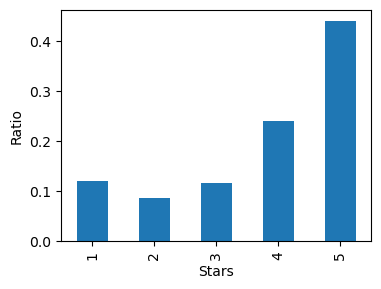

In [29]:
plot_labels(df_review, "stars")

We can find that the dataset is imbalanced.

### Data Preprocessing and Split

In [30]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test = train_test_split(df_review, test_size=250000, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=250000,
                                        random_state=42, shuffle=True)

In [31]:
df_train_raw["stars"].value_counts(normalize=False)

stars
5    1859872
4    1010555
1     506702
3     485806
2     361536
Name: count, dtype: int64

In [32]:
from sklearn.utils import resample

def undersample(df, group_size=250000):
  dfs = []

  for label in df["stars"].value_counts().keys():
    df_group = df[df["stars"] == label]
    df_group_undersampled = resample(df_group, 
                                     replace=False, 
                                     n_samples=group_size, 
                                     random_state=0)
    dfs.append(df_group_undersampled)

  return pd.concat(dfs).sample(frac=1, random_state=0)

In [33]:
df_train = undersample(df_train_raw)

In [34]:
num_review = df_review.shape[0]
num_train = df_train.shape[0]
num_dev = df_dev.shape[0]
num_test = df_test.shape[0]

(1250000, 2)


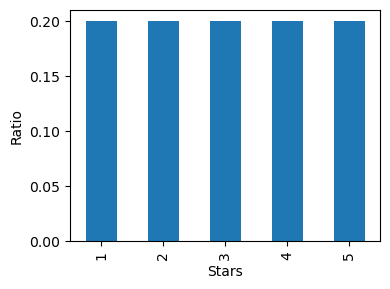

In [35]:
print(df_train.shape)
plot_labels(df_train)

(250000, 2)


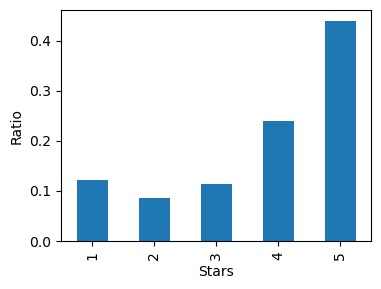

In [36]:
print(df_dev.shape)
plot_labels(df_dev)

(250000, 2)


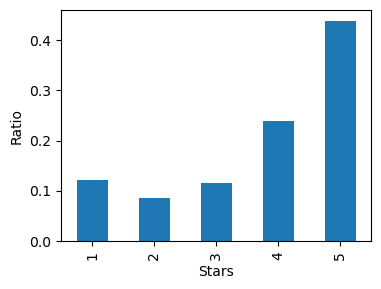

In [37]:
print(df_test.shape)
plot_labels(df_test)

In [38]:
df_train["labels"] = df_train["stars"] - 1
df_dev["labels"] = df_dev["stars"] - 1
df_test["labels"] = df_test["stars"] - 1

In [39]:
df_train.head(10)

,text,stars,labels
750261,We ordered from Greek Lady after a movie at th...,3,2
4628989,Stopped by this place on a whim searching for ...,3,2
1524775,"The three cup chicken, crystal wontons in chil...",4,3
272617,Outstanding in all respects - and our server K...,5,4
4231423,"This place is one of very few Asian markets, a...",2,1
826087,"This review is for a dinner take out order, ex...",1,0
3940772,My friend and I came last night for happy hour...,2,1
2827184,"Great atmosphere, food was awesome. New drink...",5,4
4246400,This place is flat rerrible. They manage to ru...,1,0
3905298,Seems to be closed!!!!! Today 16th May 2018\n\...,5,4


## Feature Engineering

### Tokenization

In this part, we will tokenize reviews and count numbers of tokens for each review. This information will be useful in BERT model. But we will not use these tokens directly for training models.

In [40]:
from nltk.tokenize import word_tokenize

In [41]:
ds_temp = df_train["text"].iloc[:10].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())
print(df_train["text"].iloc[0], '\n', ds_temp.iloc[0])

We ordered from Greek Lady after a movie at the Bridge one night. The chicken gyro platter was good, with the sides of garlicky potatoes and fries. I dint like the cheesecake that much...dont know bout the ambience though it looks crowded whenever we pass by. 
 ['We', 'ordered', 'from', 'Greek', 'Lady', 'after', 'a', 'movie', 'at', 'the', 'Bridge', 'one', 'night', 'The', 'chicken', 'gyro', 'platter', 'was', 'good', 'with', 'the', 'sides', 'of', 'garlicky', 'potatoes', 'and', 'fries', 'I', 'dint', 'like', 'the', 'cheesecake', 'that', 'much', 'dont', 'know', 'bout', 'the', 'ambience', 'though', 'it', 'looks', 'crowded', 'whenever', 'we', 'pass', 'by']


In [42]:
%time df_train["tokens"] = df_train["text"].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

CPU times: total: 7.3 s
Wall time: 20.6 s


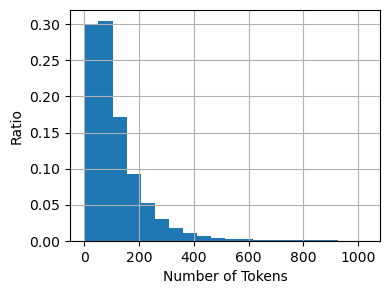

In [43]:
df_train["num_tokens"] = df_train["tokens"].map(len)
ax = df_train["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 weights=np.ones(num_train)/num_train)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.show()

In [44]:
print(len(df_train[df_train["num_tokens"] <= 128]) / len(df_train["num_tokens"]))
print(len(df_train[df_train["num_tokens"] <= 256]) / len(df_train["num_tokens"]))

0.7045616
0.9214008


In [45]:
df_train.drop(columns=["tokens", "num_tokens"], inplace=True)

In [46]:
%time df_review["num_tokens"] = df_review["text"].\
map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).\
map(lambda text: len(text.split()))

CPU times: total: 9.7 s
Wall time: 33.2 s


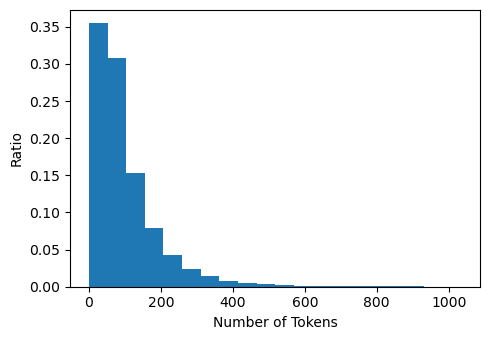

In [47]:
ax = df_review["num_tokens"].hist(bins=20,
                                  figsize=(5,3.5),
                                  grid=False,
                                  weights=np.ones(num_review)/num_review)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.savefig("num_tokens.eps")
plt.tight_layout()
plt.show()

In [48]:
print(len(df_review[df_review["num_tokens"] <= 128]) / len(df_review["num_tokens"]))
print(len(df_review[df_review["num_tokens"] <= 256]) / len(df_review["num_tokens"]))

0.7493245275502802
0.9374025155408934


In [50]:
df_review.drop(columns=["num_tokens"], inplace=True)

From the result, we can see most reviews are shorter than 256 tokens.

### Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
  vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train = vectorizer.fit_transform(df_train["text"])
  X_dev = vectorizer.transform(df_dev["text"])
  X_test = vectorizer.transform(df_test["text"])
  y_train = df_train["stars"].tolist()
  y_dev = df_dev["stars"].tolist()
  y_test = df_test["stars"].tolist()
  
  return X_train, X_dev, X_test, y_train, y_dev, y_test

In [ ]:
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

CPU times: user 6min 1s, sys: 4.42 s, total: 6min 6s
Wall time: 6min 6s


#### Test for CountVectorizer (Binary)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 11.7min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.7382096

              precision    recall  f1-score   support

           1     0.7989    0.8411    0.8195    250000
           2     0.7288    0.6754    0.7010    250000
           3     0.6736    0.7156    0.6939    250000
           4     0.7426    0.6012    0.6644    250000
           5     0.7469    0.8579    0.7985    250000

    accuracy                         0.7382   1250000
   macro avg     0.7381    0.7382    0.7355   1250000
weighted avg     0.7381    0.7382    0.7355   1250000



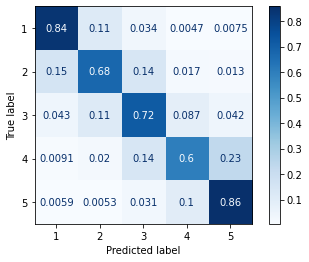


Validation Set
Accuracy: 0.628484

              precision    recall  f1-score   support

           1     0.7267    0.7436    0.7350     31118
           2     0.4263    0.4840    0.4533     22851
           3     0.4144    0.5373    0.4679     31401
           4     0.5343    0.4332    0.4785     62178
           5     0.7826    0.7722    0.7774    102452

    accuracy                         0.6285    250000
   macro avg     0.5769    0.5941    0.5824    250000
weighted avg     0.6351    0.6285    0.6293    250000



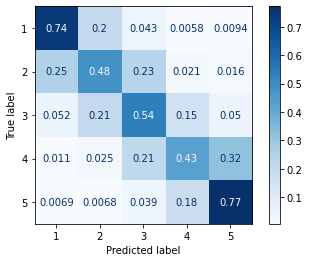


Testing Set
Accuracy: 0.630324

              precision    recall  f1-score   support

           1     0.7296    0.7450    0.7372     31175
           2     0.4274    0.4824    0.4533     22635
           3     0.4112    0.5431    0.4681     30996
           4     0.5335    0.4349    0.4791     62024
           5     0.7875    0.7718    0.7796    103170

    accuracy                         0.6303    250000
   macro avg     0.5778    0.5954    0.5834    250000
weighted avg     0.6380    0.6303    0.6316    250000



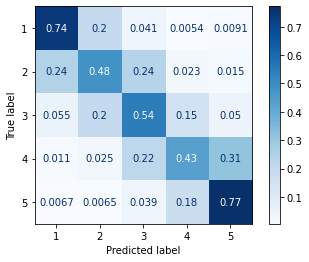

In [ ]:
evaluate_model(clf_lr, model_name="lr", model_name="lr_count_bin")

#### Test for CountVectorizer (Integer)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.7min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.701736

              precision    recall  f1-score   support

           1     0.7698    0.8192    0.7937    250000
           2     0.6740    0.6328    0.6527    250000
           3     0.6607    0.6170    0.6381    250000
           4     0.6393    0.6496    0.6444    250000
           5     0.7547    0.7901    0.7720    250000

    accuracy                         0.7017   1250000
   macro avg     0.6997    0.7017    0.7002   1250000
weighted avg     0.6997    0.7017    0.7002   1250000



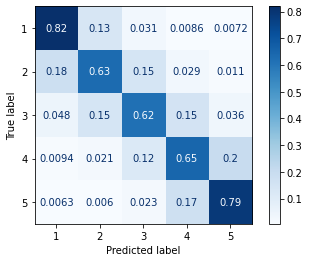


Validation Set
Accuracy: 0.632088

              precision    recall  f1-score   support

           1     0.7264    0.7511    0.7386     31118
           2     0.4358    0.5014    0.4663     22851
           3     0.4543    0.4961    0.4743     31401
           4     0.5149    0.5334    0.5240     62178
           5     0.8020    0.7266    0.7624    102452

    accuracy                         0.6321    250000
   macro avg     0.5867    0.6017    0.5931    250000
weighted avg     0.6440    0.6321    0.6369    250000



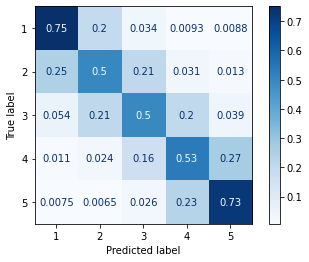


Testing Set
Accuracy: 0.632736

              precision    recall  f1-score   support

           1     0.7290    0.7534    0.7410     31175
           2     0.4332    0.4935    0.4614     22635
           3     0.4448    0.4945    0.4683     30996
           4     0.5134    0.5332    0.5231     62024
           5     0.8068    0.7282    0.7655    103170

    accuracy                         0.6327    250000
   macro avg     0.5854    0.6006    0.5919    250000
weighted avg     0.6456    0.6327    0.6379    250000



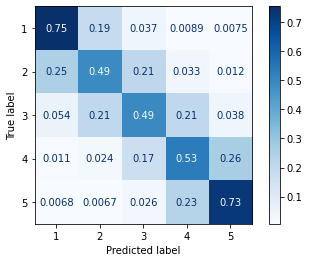

In [ ]:
evaluate_model(clf_lr, model_name="lr_count_int")

#### Test for TfidfVectorizer (Binary)

In [ ]:
X_train[:10,:]

<10x1575256 sparse matrix of type '<class 'numpy.float64'>'
	with 918 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 14.5min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.6574464

              precision    recall  f1-score   support

           1     0.7475    0.7750    0.7610    250000
           2     0.5984    0.5827    0.5905    250000
           3     0.5948    0.5759    0.5852    250000
           4     0.5979    0.5970    0.5975    250000
           5     0.7398    0.7565    0.7480    250000

    accuracy                         0.6574   1250000
   macro avg     0.6557    0.6574    0.6564   1250000
weighted avg     0.6557    0.6574    0.6564   1250000



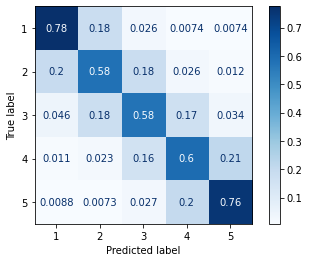


Validation Set
Accuracy: 0.63576

              precision    recall  f1-score   support

           1     0.7366    0.7436    0.7401     31118
           2     0.4375    0.5265    0.4778     22851
           3     0.4537    0.5208    0.4849     31401
           4     0.5214    0.5384    0.5298     62178
           5     0.8140    0.7217    0.7651    102452

    accuracy                         0.6358    250000
   macro avg     0.5926    0.6102    0.5995    250000
weighted avg     0.6519    0.6358    0.6420    250000



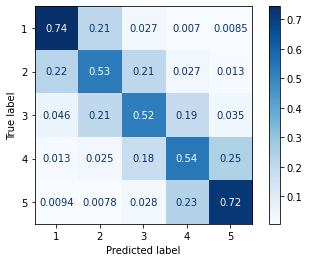


Testing Set
Accuracy: 0.636472

              precision    recall  f1-score   support

           1     0.7397    0.7443    0.7420     31175
           2     0.4366    0.5221    0.4755     22635
           3     0.4498    0.5267    0.4853     30996
           4     0.5203    0.5386    0.5293     62024
           5     0.8166    0.7208    0.7657    103170

    accuracy                         0.6365    250000
   macro avg     0.5926    0.6105    0.5996    250000
weighted avg     0.6536    0.6365    0.6431    250000



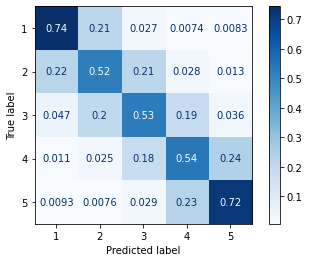

In [ ]:
evaluate_model(clf_lr, model_name="lr_tfidf_bin")

#### Test for TfidfVectorizer (Integer)

In [ ]:
X_train[:10,:]

<10x1575256 sparse matrix of type '<class 'numpy.float64'>'
	with 918 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 13.9min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.6516936

              precision    recall  f1-score   support

           1     0.7432    0.7732    0.7579    250000
           2     0.5870    0.5845    0.5858    250000
           3     0.5833    0.5615    0.5722    250000
           4     0.6064    0.5616    0.5832    250000
           5     0.7233    0.7777    0.7495    250000

    accuracy                         0.6517   1250000
   macro avg     0.6486    0.6517    0.6497   1250000
weighted avg     0.6486    0.6517    0.6497   1250000



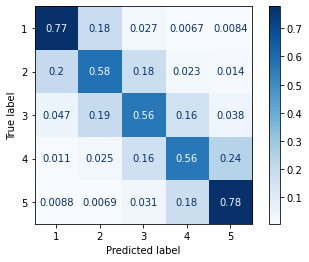


Validation Set
Accuracy: 0.63872

              precision    recall  f1-score   support

           1     0.7338    0.7476    0.7406     31118
           2     0.4350    0.5352    0.4799     22851
           3     0.4458    0.5142    0.4776     31401
           4     0.5354    0.5080    0.5213     62178
           5     0.8050    0.7462    0.7745    102452

    accuracy                         0.6387    250000
   macro avg     0.5910    0.6102    0.5988    250000
weighted avg     0.6502    0.6387    0.6431    250000



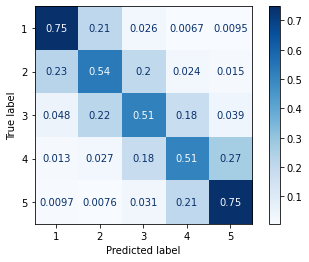


Testing Set
Accuracy: 0.640664

              precision    recall  f1-score   support

           1     0.7380    0.7481    0.7430     31175
           2     0.4367    0.5330    0.4801     22635
           3     0.4431    0.5195    0.4783     30996
           4     0.5349    0.5111    0.5227     62024
           5     0.8088    0.7461    0.7762    103170

    accuracy                         0.6407    250000
   macro avg     0.5923    0.6116    0.6001    250000
weighted avg     0.6530    0.6407    0.6454    250000



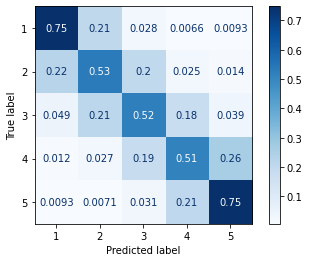

In [ ]:
evaluate_model(clf_lr, model_name="lr_tfidf_int")